In [1]:
import pandas as pd

# Load the dataset
file_path = "C:/Users/azizb/Downloads/sleepdata.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Start;End;Sleep quality;Time in bed;Wake up;Sleep Notes;Heart rate;Activity (steps)
0,2014-12-29 22:57:49;2014-12-30 07:30:13;100%;8...
1,2014-12-30 21:17:50;2014-12-30 21:33:54;3%;0:1...
2,2014-12-30 22:42:49;2014-12-31 07:13:31;98%;8:...
3,2014-12-31 22:31:01;2015-01-01 06:03:01;65%;7:...
4,2015-01-01 22:12:10;2015-01-02 04:56:35;72%;6:...


In [2]:
# Reload the dataset with proper delimiter
data = pd.read_csv(file_path, delimiter=';')

# Display the first few rows of the dataset to confirm the structure
data.head()


,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


In [3]:
# Step 1: Delete the "Activity (steps)" column
data = data.drop(columns=["Activity (steps)"])

# Step 2: Remove rows with missing values in "Wake up"
data = data.dropna(subset=["Wake up"])

# Step 3: Transform the "Wake up" values
data["Wake up"] = data["Wake up"].replace({":)": 0, ":|": 0, ":(": 1})

# Step 4: Keep relevant columns
data = data[["Heart rate", "Time in bed", "Sleep quality", "Wake up"]]

# Display the cleaned dataset
data.head()


C:\Users\azizb\AppData\Local\Temp\ipykernel_13336\1445479294.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Wake up"] = data["Wake up"].replace({":)": 0, ":|": 0, ":(": 1})


,Heart rate,Time in bed,Sleep quality,Wake up
0,59.0,8:32,100%,0
1,72.0,0:16,3%,0
2,57.0,8:30,98%,0
4,68.0,6:44,72%,0
5,60.0,7:12,83%,0


In [4]:
# Convert "Time in bed" to total minutes for easier comparisons
def time_to_minutes(time_str):
    """Convert time in HH:MM format to total minutes."""
    try:
        hours, minutes = map(int, time_str.split(':'))
        return hours * 60 + minutes
    except ValueError:
        return None

data["Time in bed (minutes)"] = data["Time in bed"].apply(time_to_minutes)

# Convert "Sleep quality" to numeric percentage
data["Sleep quality (%)"] = data["Sleep quality"].str.rstrip('%').astype(float)

# Apply depression rule
def classify_depression(row):
    """Classify depression based on heart rate, sleep quality, and time in bed."""
    if (
        row["Heart rate"] > 65 and
        row["Sleep quality (%)"] < 50 and
        (row["Time in bed (minutes)"] < 330 or row["Time in bed (minutes)"] > 540)
    ):
        return 1  # Depressed
    return 0  # Not depressed

data["Depression (Predicted)"] = data.apply(classify_depression, axis=1)

# Display the updated dataset with the depression classification
data.head()


,Heart rate,Time in bed,Sleep quality,Wake up,Time in bed (minutes),Sleep quality (%),Depression (Predicted)
0,59.0,8:32,100%,0,512,100.0,0
1,72.0,0:16,3%,0,16,3.0,1
2,57.0,8:30,98%,0,510,98.0,0
4,68.0,6:44,72%,0,404,72.0,0
5,60.0,7:12,83%,0,432,83.0,0


In [5]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [14]:
def train_and_predict(data):
    # Define features and target
    features = data[["Heart rate", "Time in bed (minutes)", "Sleep quality (%)"]]
    target = data["Wake up"]

    # Handle missing values using SimpleImputer (mean strategy for numerical data)
    imputer = SimpleImputer(strategy="mean")
    features = imputer.fit_transform(features)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Train a Random Forest Classifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Return the model, X_test, and y_test
    return model, X_test, y_test


Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
y_pred shape: (50,)
Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00    

C:\Users\azizb\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


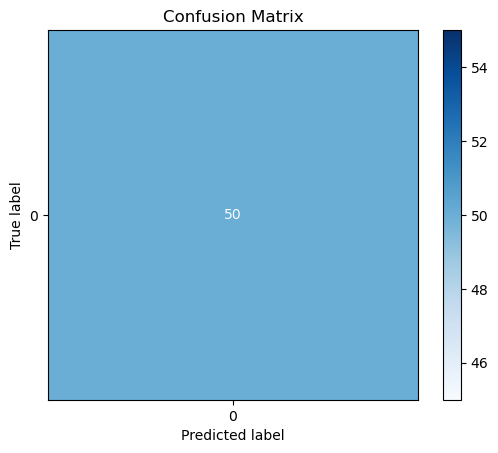

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_test_model(model, X_test, y_test):
    # Print the model parameters
    print("Model parameters:")
    print(model.get_params())

    # Make predictions
    y_pred = model.predict(X_test)
    print(f"y_pred shape: {y_pred.shape}")

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%\n")

    # Detailed classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix using correct display labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example usage (assuming you already split your data)
model, X_test, y_test = train_and_predict(data)  # Train the model

# Evaluate and test the model by passing only the model
evaluate_and_test_model(model, X_test, y_test)


In [20]:
# Train the model and get X_test, y_test for testing predictions
model, X_test, y_test = train_and_predict(data)  # This will return a tuple

# Test the prediction function
predictions = test_prediction(model, X_test)

# Optionally, you can also calculate and print accuracy to check if the predictions are correct
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")



Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Predictions on the test set:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy on test data: 100.00%
